# Implementation Report - NFL Play Prediction Using a Neuro-Genetic Hybrid Model 

This notebook demonstrates the implementation of a Neuro-Genetic hybrid model to predict the success or failure of an NFL Play. The code along with the dataset can be found in our Github Repository (https://github.com/madil27/NFLpredictions). 


## Dataset
The dataset used contains information on every NFL play that has been run since 2009. It’s hosted on Kaggle:
<a href="https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016"> Link to dataset</a>

The information on each attribute in the dataset can be located at this <a href="https://github.com/maksimhorowitz/nflscrapR/blob/master/R/scrape_play_by_play.R">link </a>


The step-by-step implementation is explained in subsequent parts of the notebook.


In [1]:
import pandas as pd
import matplotlib
from sklearn import preprocessing
import numpy as np
import numpy
import random
import pickle
import matplotlib.pyplot
%matplotlib inline

In [2]:
df = pd.read_csv('dataset.csv')

/home/adil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

The following steps are implemeneted for cleaning the dataset: </br>
* Only playtypes "run" and "pass" are considered. Special playtypes such as goals, punts, sacks, fumbles etc are of no interest to us.
* We only consider those data points in which the value of down is 1,2,3 or 4. 
* We replace NaNs with 'unknown'. 

## Feature Selection

There is a lot of information in this data set (255 columns).Apart from the actual play the dataset describes injuries, timeouts, quarterback substitutions, penalties, and other information. Since we are only interested in the actual plays we need to filter out all the irrelevant information.

The 12 features we ended up using for our classification task are:

| Features | Type | Description |
| --- | --- | --- |
| **posteam** | Categorical |  Team in possession |
| **defteam** | Categorical |  Team in defense |
| **game_half** | Categorical |  Current Half (first, second, overtime) |
| **half_seconds_remaining** | Numerical |  Seconds remaining in half end |
| **yardline_100** | Numerical |  Distance to the 100 yardline |
| **down** | Categorical |  Current down in play (1st,2nd,3rd,4th) |
| **ydstogo** | Numerical |  Yards to touchdown/firstdown in the play |
| **shotgun** | Binary | Binary indicator for whether or not the play was in shotgun |
| **play_type** | Categorical |  String indicating the type of play |
| **pass_location** | Categorical |  Location of pass in the ground(left,right) |
| **run_location** | Categorical |  Location of run in the ground(left,right) |
| **pass_length** | Categorical |  Length of pass(small,long) |

These features best describe the relevant game situation and the play being used by the team in offence. 

## Targets

Apart from the features we also have to extract the ground truth labels of each play. The possible target variables include:

| Label | Type | Description |
| --- | --- | --- |
| **Success** | Binary |  Indicates whether a play resulted in a first down or a touchdown. |
| **Yards Gained** | Continuous |  Indicates how many yards a team has gained through this play. |

When we use the binary value success we define successful plays as plays which either obtain a first
down or score a touchdown. In all other cases the play will be classified as failure. In this phase of the project, we make use of just the first target variable only i.e "Success". We plan on predicting the yards gained in further phases of the project.


## Data Encoding 

Some of our features have categorical values. For example either of the features T eam and
Opponent take on a value representing one of the 32 teams. Simply numbering the teams from
1 to 32 would not represent the real situation because team number 1 is not closer to team number 2 than it is to
team number 32. Consequently, we need a more sophisticated encoding. For that reason, we have chosen
one-hot encoding for our categorical features. That is, each categorical feature is replaced by k binary features where k is the number of possible values.

Encoding all our categorical features of our data set expands the size from 12 to 98 dimensions. Moreover, we standardize features such as yardline100 and half seconds remaining between 0 to 1.





In [3]:
def bucketize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def bucketize_df(df):
    df['ydstogo'] = [bucketize(x, 4, 5) for x in df['ydstogo']]
    return df

def get_success(arguments):
    t, f1, f2, f3 = arguments
    if(t == 1.0 or f1 == 1.0 or f2 == 1.0 or f3 == 1.0):
        return 1
    else:
        return 0

data = df[(df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]
data =  data[['posteam', 'defteam', 'game_half', 'half_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'play_type', 'pass_location', 'run_location', 'pass_length', 'touchdown', 'first_down_rush', 'first_down_penalty', 'first_down_pass']]
data = data.replace(np.nan, 'unknown', regex=True)
data["success"] = data[['touchdown', 'first_down_rush', 'first_down_penalty', 'first_down_pass']].apply(get_success, axis=1)
data =  data[['posteam', 'defteam', 'game_half', 'half_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'play_type', 'pass_location', 'run_location', 'pass_length', 'success']]
data = bucketize_df(data)
#one hot encoding
data = pd.get_dummies(data, columns=['ydstogo','posteam', 'defteam', 'game_half', 'down', 'play_type', 'pass_location', 'run_location', 'pass_length'])
data = data[data['half_seconds_remaining'] != 'unknown']
#standardizing
data['yardline_100']/=100
data['half_seconds_remaining'] /= 1800

In [4]:
# USING A SUBSET FOR TESTING PURPOSES
data = data[:1000]

In [5]:
data_o = data["success"]
data_i = data
del data_i["success"]
data_inputs = data_i.to_numpy()
data_inputs = data_inputs.astype('float64')
data_outputs = data_o.to_numpy()
data_outputs = data_outputs.astype('float64')

## Neuro-Genetic Model 

GA creates multiple solutions to a given problem and evolves them through a number of generations. Each solution holds all parameters that might help to enhance the results. For NN, weights in all layers help achieve high accuracy. Thus, a single solution in GA will contain all weights in the NN.

### Fitness Function 

GA uses a fitness function to returns a fitness value for each solution. The higher the fitness value the better the solution. The best solutions are returned as parents in the parents selection step.

One of the common fitness functions for a classifier such as NN is the accuracy. It is the ratio between the correctly classified samples and the total number of samples.In this implementation, we use NN's accuracy as a measure of the fitness function for the genetic algorithm.

### Implementation

Our implementation of the algorithm is as follows:

1. It first reads the features and the target labels as numpy ndarrays.

2. It then creates the NN architecture, using the number of hidden layer and output layer neurons as arguments.

3. It then generates the initial solutions(weights for the NN) randomly.

4. It then loops through a number of generations by calculating the fitness values for all solutions.

5. It then selects the best parents, applies crossover and mutation, and finally creates the new population.

6. The step 4 and 5 are repeated until we either get the desired accuracy or we iterate through all the generation.


In [6]:
## NEURAL NETWORK FUNCTIONS


## The model is implemented using help from: https://github.com/ahmedfgad/NeuralGenetic

def sigmoid(inpt):
    return 1.0/(1.0+numpy.exp(-1*inpt))

def relu(inpt):
    result = inpt
    result[inpt<0] = 0
    return result

def predict_outputs(weights_mat, data_inputs, data_outputs, activation="relu"):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = numpy.matmul(r1, curr_weights)
            if activation == "relu":
                r1 = relu(r1)
            elif activation == "sigmoid":
                r1 = sigmoid(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions/data_outputs.size)*100
    return accuracy, predictions
    
def fitness_func(weights_mat, data_inputs, data_outputs, activation="relu"):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inputs, data_outputs, activation=activation)
    return accuracy

## GENETIC ALGORITHM FUNCTIONS

def mat_to_vector(mat_pop_weights):
    pop_weights_vector = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = numpy.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        pop_weights_vector.append(curr_vector)
    return numpy.array(pop_weights_vector)


def vector_to_mat(vector_pop_weights, mat_pop_weights):
    mat_weights = []
    for sol_idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[sol_idx, layer_idx].size
            curr_vector = vector_pop_weights[sol_idx, start:end]
            mat_layer_weights = numpy.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return numpy.reshape(mat_weights, newshape=mat_pop_weights.shape)

def select_mating_pool(pop, fitness, num_parents):
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    crossover_point = numpy.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_percent):
    num_mutations = numpy.uint32((mutation_percent*offspring_crossover.shape[1])/100)
    mutation_indices = numpy.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    for idx in range(offspring_crossover.shape[0]):
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    return offspring_crossover


In [12]:
sol_per_pop = 10
num_parents_mating = 5
num_generations = 1000
mutation_percent = 10

initial_pop_weights = []
for curr_sol in numpy.arange(0, sol_per_pop):
    HL1_neurons = 75
    input_HL1_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(data_inputs.shape[1], HL1_neurons))
    HL2_neurons = 30
    HL1_HL2_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                             size=(HL1_neurons, HL2_neurons))
    output_neurons = 2
    HL2_output_weights = numpy.random.uniform(low=-0.1, high=0.1, 
                                              size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(numpy.array([input_HL1_weights, 
                                                HL1_HL2_weights, 
                                                HL2_output_weights]))

pop_weights_mat = numpy.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = numpy.empty(shape=(num_generations))

print("Running the Algorithm")
for generation in range(num_generations):
    pop_weights_mat = vector_to_mat(pop_weights_vector, 
                                       pop_weights_mat)

    fitness = fitness_func(pop_weights_mat, 
                          data_inputs, 
                          data_outputs, 
                          activation="sigmoid")
    accuracies[generation] = fitness[0]

    parents = select_mating_pool(pop_weights_vector, 
                                    fitness.copy(), 
                                    num_parents_mating)

    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))

    offspring_mutation = mutation(offspring_crossover, 
                                     mutation_percent=mutation_percent)

    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

print("The num_generations specified (" + str(num_generations) + ") are completed")
pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
print("Accuracy of the best solution is : ", acc)


Running the Algorithm
The num_generations specified (1000) are completed
Accuracy of the best solution is :  74.5


## Iteration vs Fitness Plot

Based on 1,000 generations, a plot is created at the end of this file using Matplotlib visualization library that shows how the accuracy changes across each generation. It is shown in the next figure. After 1,000 iterations, the accuracy is around 75%.

We can increase this by increasing the number of generations and by using the entire dataset. As of now, we are using the subset of the dataset, as its taking a lot of time on the complete dataset and we plan on running it on a cluster. 


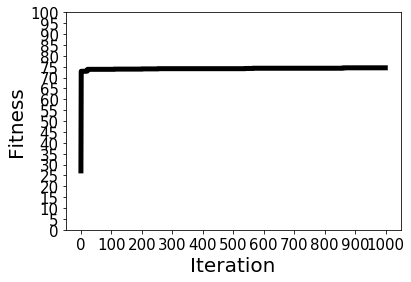

<Figure size 432x288 with 0 Axes>

In [13]:
matplotlib.pyplot.plot(accuracies, linewidth=5, color="black")
matplotlib.pyplot.xlabel("Iteration", fontsize=20)
matplotlib.pyplot.ylabel("Fitness", fontsize=20)
matplotlib.pyplot.xticks(numpy.arange(0, num_generations+1, 100), fontsize=15)
matplotlib.pyplot.yticks(numpy.arange(0, 101, 5), fontsize=15)
matplotlib.pyplot.show()